In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sim_file = '/group/ag_compstatphys/data/tolga/simulation/vle_vacuum_test669.h5'

In [3]:
def wrap_pbc(positions, box_edges):
    """
    Wraps coordinates into the centered box [-L/2, L/2].
    """
    # Extract diagonal L from box edges
    L = np.diag(box_edges)

    return ((positions + L/2) % L) - L/2

def plot_density_from_position(h5md_file, frame = -1):
    # Define histogram bins
    bin_edges = np.linspace(-50, 50, 101)  # 50 bins from 0 to 100
    hist_counts = np.zeros(len(bin_edges) - 1)

    with h5py.File(h5md_file, 'r') as f:
        dataset = f['/particles/all/position/value']
    
        data = dataset[frame,:,2]
        counts, _ = np.histogram(data, bins=bin_edges)
        hist_counts += counts
        #print(dataset.shape)
    # Plot the final histogram
    plt.bar(bin_edges[:-1], hist_counts, width=np.diff(bin_edges), align='edge')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram from HDF5 Dataset')
    plt.show()
    

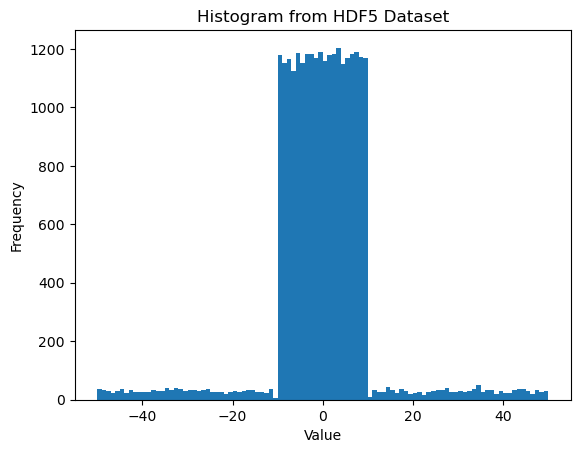

In [4]:
plot_density_from_position(sim_file, 0)

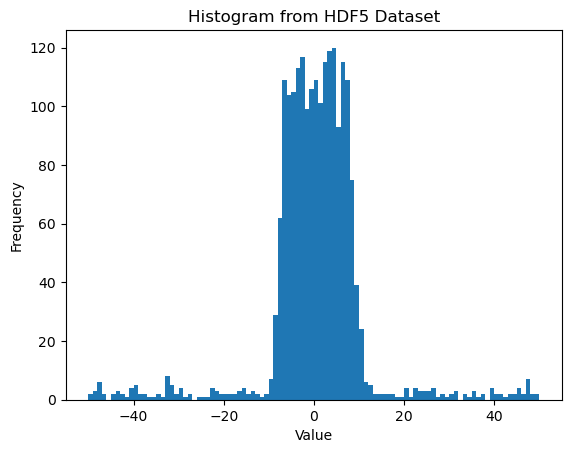

In [5]:
plot_density_from_position(sim_file, -1)

In [5]:
with h5py.File(sim_file, 'r') as f:
    temp = np.array(f['/observables/temperature/value'])
    pot_energy = np.array(f['/observables/potential_energy/value'])

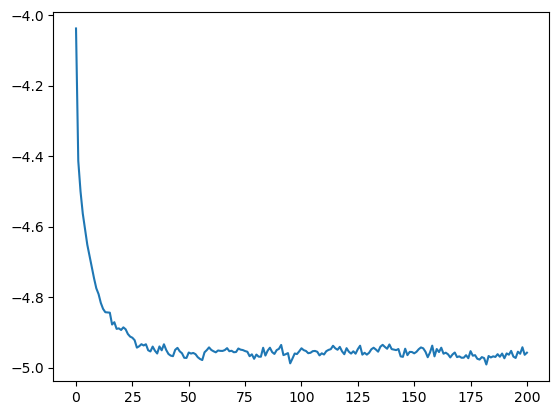

In [6]:
plt.plot(pot_energy)

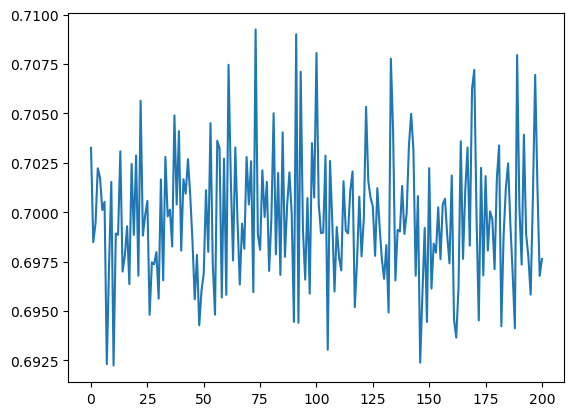

In [7]:
plt.plot(temp)

In [8]:
def wrap_pbc(positions, box_edges):
    """
    Wraps coordinates into the centered orthorhombic box [-L/2, L/2].
    """
    L = np.array([box_edges[0,0], box_edges[1,1], box_edges[2,2]])
    return ((positions + L/2) % L) - L/2


def plot_density_from_position(h5md_file, frame=-1, nbins=100):
    with h5py.File(h5md_file, 'r') as f:
        
        # --- Read positions ---
        pos = f['/particles/all/position/value'][frame]
        
        # --- Read box edges (HALMD stores box edge matrices per frame) ---
        box = f['/particles/all/box/edges']
        Lx, Ly, Lz = box[0,0], box[1,1], box[2,2]
        A = Lx * Ly
        
        # --- Wrap positions into [-L/2, +L/2] ---
        pos_wrapped = wrap_pbc(pos, box)
        z = pos_wrapped[:,2]
        
        # --- Histogram ---
        bin_edges = np.linspace(-Lz/2, Lz/2, nbins+1)
        counts, _ = np.histogram(z, bins=bin_edges)

        # --- Convert to density ---
        dz = bin_edges[1] - bin_edges[0]
        rho = counts / (A * dz)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        
    # --- Plot ---
    plt.plot(bin_centers, rho)
    plt.xlabel('z')
    plt.ylabel('density ρ(z)')
    plt.title('Density profile from HALMD trajectory')
    plt.grid(True)
    plt.show()

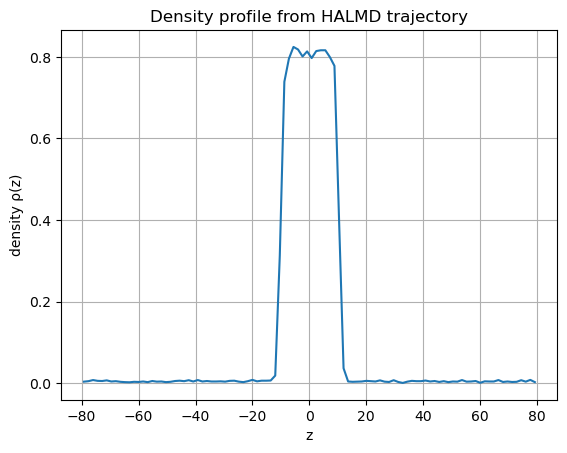

In [9]:
plot_density_from_position(sim_file)

In [24]:
def plot_density_time_averaged(h5md_file, nbins=100):
    with h5py.File(h5md_file, 'r') as f:

        pos_ds  = f['/particles/all/position/value']
        box_ds  = f['/particles/all/box/edges']

        n_frames = pos_ds.shape[0]

        # Use only the last half of the frames
        start_frame = n_frames // 2
        frames_to_use = range(start_frame, n_frames)

        # Read box size from the *first* frame used (assuming constant box)
        box = box_ds
        Lx, Ly, Lz = box[0,0], box[1,1], box[2,2]
        A = Lx * Ly

        # Histogram bins across z in [-Lz/2, Lz/2]
        bin_edges = np.linspace(-Lz/2, Lz/2, nbins + 1)
        hist_sum = np.zeros(nbins)

        # Loop over frames
        for frame in frames_to_use:
            pos = pos_ds[frame]
            box = box_ds

            # wrap
            pos_wrapped = wrap_pbc(pos, box)
            z = pos_wrapped[:, 2]

            # histogram
            counts, _ = np.histogram(z, bins=bin_edges)
            hist_sum += counts

        # Normalize to density
        dz = bin_edges[1] - bin_edges[0]
        rho = hist_sum / (len(frames_to_use) * A * dz)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot --------------------------------------------------------
    plt.plot(bin_centers, rho)
    plt.xlabel('z')
    plt.ylabel('density ρ(z)')
    plt.title('Time-averaged density profile (last half of trajectory)')
    plt.grid(True)
    plt.show()

    return bin_centers, rho


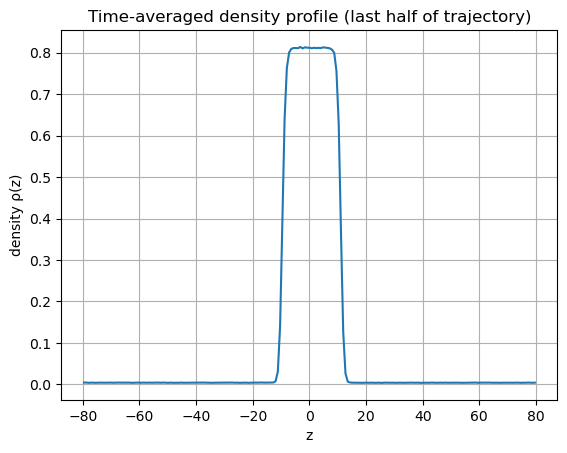

In [25]:
bin_centers, rho = plot_density_time_averaged(sim_file, nbins = 201)

In [30]:
np.mean(rho[np.where(rho > 0.80)])

0.8104701539294554

In [31]:
np.mean(rho[np.where(rho < 0.005)])

0.004278749889497878

In [19]:
def tanh_vl(z, rho_liq, rho_vap, z_0, w):
    return rho_vap + 0.5*(rho_liq - rho_vap)*(1 - np.tanh((z-z_0)/w))

In [20]:
z = np.linspace(-80, 80, 1000)

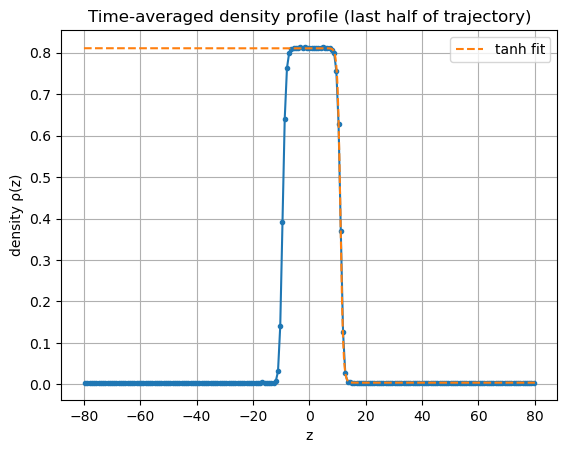

In [44]:
plt.plot(bin_centers, rho, '-o', markersize = 3)
plt.xlabel('z')
plt.ylabel('density ρ(z)')
plt.title('Time-averaged density profile (last half of trajectory)')
plt.grid(True)
plt.plot(z, tanh_vl(z, 0.8104701539294554, 0.004278749889497878, 11, 1), '--',label = 'tanh fit')
plt.legend()
plt.show()